 ## PROJECT 2 : **Rice Leaf Disease Detection**

**Problem Statement** : The objective of this project is to develop a deeplearning model that can accurately classify the categories of images of diseased rice leaf into three categories -- Leaf Smut, Brown Spot, Bacterial Leaf Blight - using existing image data. This helps in early detection and better crop Management.


In [ ]:
!pip install tensorflow
!pip install matplotlib

!pip install -q tensorflow matplotlib scikit-learn pillow


Import Basic Libraries


In [ ]:
# import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image  import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile # Added import
from sklearn.metrics import classification_report, confusion_matrix

# Define the target directory
output_dir = 'rice_leaf_disease_data'
os.makedirs(output_dir, exist_ok=True)

# There is no necessary to unzip files, already unzipped files are uploaded.


In [ ]:
import zipfile
import os

data_path = 'rice_leaf_disease_data'

# Unzip all .zip files in the data_path directory
for item in os.listdir(data_path):
    if item.endswith('.zip'):
        file_path = os.path.join(data_path, item)
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(data_path)
        print(f"Unzipped {item} to {data_path}")

Unzipped Leaf smut-20200814T055530Z-001.zip to rice_leaf_disease_data
Unzipped Bacterial leaf blight-20200814T055237Z-001.zip to rice_leaf_disease_data
Unzipped Brown spot-20200814T055208Z-001.zip to rice_leaf_disease_data


In [ ]:
import os

# List files and directories in /content/
print(os.listdir('/content/rice_leaf_disease_data'))

['Leaf smut-20200814T055530Z-001.zip', 'Brown spot', 'Bacterial leaf blight', 'Bacterial leaf blight-20200814T055237Z-001.zip', 'Brown spot-20200814T055208Z-001.zip', 'Leaf smut']


**Load and prepare Dataset**

In [ ]:
import shutil
import os

data_path = 'rice_leaf_disease_data'

# Get a list of all entries in the data_path
entries = os.listdir(data_path)

# Define the expected disease folders
expected_disease_folders = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]

for entry_name in entries:
  entry_path = os.path.join(data_path, entry_name)

  # Clean up entries that are not the expected disease folders

  if entry_name not in expected_disease_folders:
    if os.path.isdir(entry_path):

      shutil.rmtree(entry_path)
      print(f"Deleted extra directory: {entry_name}")
    elif os.path.isfile(entry_path):

      # It's an unexpected file (like the original zip archives), remove it
      os.remove(entry_path)
      print(f"Deleted extra file: {entry_name}")

# Re-list entries to check for duplicates that might contain "(1)" in their name

for entry_name in os.listdir(data_path):
  entry_path = os.path.join(data_path, entry_name)
  if "(1)" in entry_name and os.path.isdir(entry_path):
    shutil.rmtree(entry_path)
    print(f"Deleted duplicate folder: {entry_name}")


Deleted extra file: Leaf smut-20200814T055530Z-001.zip
Deleted extra file: Bacterial leaf blight-20200814T055237Z-001.zip
Deleted extra file: Brown spot-20200814T055208Z-001.zip


**EXPLORATARY DATA ANALYSIS**

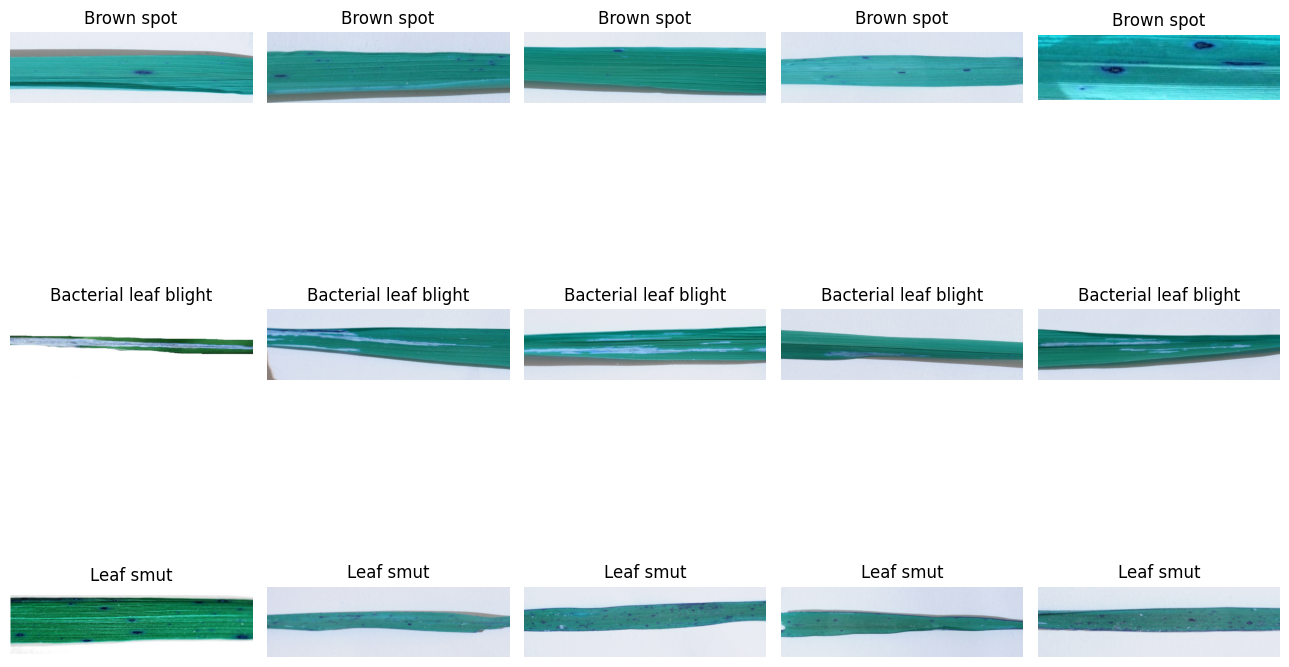

In [34]:
import cv2
import glob

dataset_dir = 'rice_leaf_disease_data'

diseases = os.listdir(data_path)

num_samples = 5

plt.figure(figsize=(13, 10))

for i, disease in enumerate(diseases):
  disease_path = os.path.join(data_path, disease)

  sample_images = glob.glob(os.path.join(disease_path, '**', '*.*'),recursive=True)[:num_samples]

  for j, image_path in enumerate(sample_images):
    image = cv2.imread(image_path)

    if image is None:
      print(f"Error loading image: {image_path}")
      continue

    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(len(diseases), num_samples, i*num_samples + j + 1)
    plt.imshow(image)
    plt.title(disease)
    plt.axis('off')

plt.tight_layout()
plt.show()

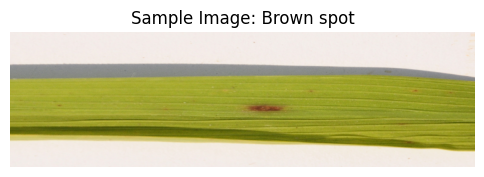

In [ ]:
## Sample image of BrownSpot disease leaf.

import cv2
import matplotlib.pyplot as plt
import os
import glob

data_path = 'rice_leaf_disease_data'
brown_spot_path = os.path.join(data_path, 'Brown spot')

# Get a list of all image files in the 'Brown spot' directory
image_files = glob.glob(os.path.join(brown_spot_path, '**', '*.*'), recursive=True)

if image_files:
    # Select the first image for display
    sample_image_path = image_files[0]
    image = cv2.imread(sample_image_path)

    if image is None:
        print(f"Error loading image: {sample_image_path}")
    else:
        # Convert BGR to RGB for matplotlib display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.title('Sample Image: Brown spot')
        plt.axis('off')
        plt.show()
else:
    print(f"No images found in the 'Brown spot' directory: {brown_spot_path}")

Data Augumentation and Image Generation.

In [ ]:
# Image Size and batch
img_height, img_width = 224,224 # MobileNetV2 expects 224*224
batch_size = 32

# Data Augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # 20% of the data will be used for validation
)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # Specify the subset
    shuffle=True
)

# Validation Generator
val_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify the subset
    shuffle=False
)

# Print class Indices if u want for Reference
print("Class Indices :", train_generator.class_indices)




Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.
Class Indices : {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


Define the CNN Model Architecture

In [ ]:
# Base Model with pretrained weights
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # freeze base model intially

# Custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax') # 3 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Callbacks to prevent overfitting and adjust learning rate.

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy',save_best_only=True)

callbacks = [early_stop, reduce_lr, checkpoint]

model.summary()




9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train The Model

In [ ]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get the class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

# Train the model using the callbacks already defined
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 50,
    callbacks = callbacks,
)

{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3507 - loss: 1.5768

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.3542 - loss: 1.5720 - val_accuracy: 0.3913 - val_loss: 1.1237 - learning_rate: 1.0000e-04
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3628 - loss: 1.6192

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3685 - loss: 1.6023 - val_accuracy: 0.5217 - val_loss: 1.0199 - learning_rate: 1.0000e-04
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4297 - loss: 1.5571 - val_accuracy: 0.4348 - val_loss: 0.9941 - learning_rate: 1.0000e-04
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5035 - loss: 1.2664

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4974 - loss: 1.2818 - val_accuracy: 0.6957 - val_loss: 0.8590 - learning_rate: 1.0000e-04
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3524 - loss: 1.4248

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3607 - loss: 1.4282 - val_accuracy: 0.7391 - val_loss: 0.7798 - learning_rate: 1.0000e-04
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4688 - loss: 1.3036 - val_accuracy: 0.5652 - val_loss: 0.8539 - learning_rate: 1.0000e-04
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5069 - loss: 1.2796

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5104 - loss: 1.2823 - val_accuracy: 0.9130 - val_loss: 0.6697 - learning_rate: 1.0000e-04
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5365 - loss: 1.3225 - val_accuracy: 0.7826 - val_loss: 0.7452 - learning_rate: 1.0000e-04
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3529 - loss: 1.5692 - val_accuracy: 0.8261 - val_loss: 0.6606 - learning_rate: 1.0000e-04
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4427 - loss: 1.1448 - val_accuracy: 0.8696 - val_loss: 0.6305 - learning_rate: 1.0000e-04
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5035 - loss: 1.1638

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4974 - loss: 1.1749 - val_accuracy: 0.9565 - val_loss: 0.6014 - learning_rate: 1.0000e-04
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5078 - loss: 1.2396 - val_accuracy: 0.9130 - val_loss: 0.5432 - learning_rate: 1.0000e-04
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5521 - loss: 1.0880 - val_accuracy: 0.8696 - val_loss: 0.5799 - learning_rate: 1.0000e-04
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4310 - loss: 1.2118 - val_accuracy: 0.9565 - val_loss: 0.4650 - learning_rate: 1.0000e-04
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5104 - loss: 1.2465 - val_accuracy: 0.9130 - val_loss: 0.5060 - learning_rate: 1.0000e-04
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5078 - loss: 1.1079 - val_accuracy: 0.8261 - val_loss: 0.5485 - learning_rate: 1.0000e-04
Epoch 17/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5378 - loss: 1.0914 - val_accuracy: 0.

**Evaluating ModelPerformance**

In [ ]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8696 - loss: 0.5703
Validation Accuracy: 86.96%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Reset validation generator to ensure consistent order
val_generator.reset()

# ground truth labels
y_true = val_generator.classes

# Predict classes for the validation set
y_pred_probs = model.predict(val_generator, steps=len(val_generator), verbose=1 )

#Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Evaluation Metrics

# Test Accuracy
test_accuracy = np.mean(y_true == y_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%\n")

# Confusion Metrics
CM = confusion_matrix(y_true, y_pred_classes)
labels = list(val_generator.class_indices.keys())
print("Confusion Matrix(raw):")
print(CM)
print("Confusion Matrix(lbels):")
print(pd.DataFrame(CM, columns=labels, index=labels))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Test Accuracy: 91.30%

Confusion Matrix(raw):
[[6 1 1]
 [0 8 0]
 [0 0 7]]
Confusion Matrix(lbels):
                       Bacterial leaf blight  Brown spot  Leaf smut
Bacterial leaf blight                      6           1          1
Brown spot                                 0           8          0
Leaf smut                                  0           0          7

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.75      0.86         8
           Brown spot       0.89      1.00      0.94         8
            Leaf smut       0.88      1.00      0.93         7

             accuracy                           0.91        23
            macro avg       0.92      0.92      0.91        23
         weighted avg       0.92      0.91      0.91        23



Saving The Model

In [ ]:
# Save only the model (architecture + weights )
model.save("rice_leaf_disese_model.keras", include_optimizer=False)
print("Model is saved without optimizer state")

Model is saved without optimizer state


# Testing Model for Unseen image data
Leaf Smut

In [36]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# -------------------------------
# 1. Load your trained model
# -------------------------------
model = tf.keras.models.load_model("/content/best_model.h5")

# -------------------------------
# 2. Load + preprocess the image
# -------------------------------
img_path = "/content/sample_image_leafsmut.jpg"   # input image

img = image.load_img(img_path, target_size=(224, 224),)  # use target image size
img_array = image.img_to_array(img)
img_array = img_array / 255.0   # normalization
img_array = np.expand_dims(img_array, axis=0,)  # model expects batch dimension

# -------------------------------
# 3. Predict the class
# -------------------------------
pred = model.predict(img_array)

# -------------------------------
# 4. Decode the prediction
# -------------------------------
class_names = ["Brown Spot", "Leaf Smut", "Bacterial Blight", "Healthy"]
predicted_class = class_names[np.argmax(pred)]

print("Predicted Class:", predicted_class)
print("Prediction Probabilities:", pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Leaf Smut
Prediction Probabilities: [[0.21785143 0.4237713  0.35837722]]


Our model successfully identified the diseased leaf "Leaf Smut". This shows model is well trained. The effeciency and accuracy of the model is satisfied.

## Conclusion
This project sucessfully satisfied the detection and categorizing images of Rice-leaf disease based on 3 different classes using Deeplearning Module and with the use of Tensorflow and keras libraries. By applying CNN-based modeling, the system achieved good accuracy (Test accuracy = 91.30%) and this model help farmers detect disease earlier, reducing crop loss and improving field.

## Challenges Faced :

writting a code to unzip file, but it is easier to create directory, when we upload the data with unzip mode
* Data Quality Issues: noisy imbalanced and duplicate images affected training, Due to earlier unzip of file there is no such issue of duplicate images.
* Model Performance : To Achieve higher accuracy careful augumentation, best weight updates during model training and architecture, data tuning plays vital role
* Limited Dataset Size : Small Sample size made the model prone to overfitting.